## Plot Images and Bounding Boxes from YOLO Output

In [2]:
# load packages to visualize yolo bbox
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

import os
import json
import sys
import re

# Set up dirs for jupyter notebook using cwd
dir_name = 'PGHComputerVision'
root = os.getcwd()
# sub out any text after dir_name to get project directory
root = re.sub(rf"{dir_name}.*", dir_name, root)

# create code and data directories
code_root = os.path.join(root, 'Code')
data_root = os.path.join(root, 'Data')

# Read in helper function
sys.path.append( os.path.join(code_root, 'helpers') )


In [3]:
# load detected objects df
detections = pd.read_csv( os.path.join( data_root, 'YOLO_output', 'YOLOv8m', 'detections.csv') )
detections.head()

segment_id  img_id  object_id  confidence  bbox_size        x1  \
0  104197837-271197326  h1_009          0      0.9183   74265.74  399.3403   
1  104197837-271197326  h1_007          0      0.9593   88640.84   18.9590   
2  104197837-271197326  h1_013          0      0.9095   84736.62    0.5696   
3  104197837-271197326  h1_013          1      0.7939    1912.87  369.3296   
4  104197837-271197326  h1_013          2      0.7383    1495.24  289.6362   

         y1        x2        y2   class  
0  279.4324  639.5289  588.6301   truck  
1  391.8408  430.2413  607.3639     car  
2  189.2771  253.1547  524.7546   truck  
3  338.6563  401.4716  398.1696  person  
4  329.1837  316.0912  385.7040  person

In [6]:
# read in images.txt
images_txt_path = os.path.join(data_root, 'GSV', 'Res_640', 'PittsburghDowntown_2024-03-20', 'images.txt')
images_df = pd.read_csv(images_txt_path, sep=' ', header=None)

# rename columns 
cols = ['segment_id', 'filename', 'image_panoid', 'date', 'query_counter', 'lat', 'lon', 'end']
images_df.columns = cols

# drop "end" column
images_df.drop('end', axis=1, inplace=True)

# convert date to datetime
images_df['date'] = pd.to_datetime(images_df['date'], format='%Y-%m-%d')

# create img_id
images_df['img_id'] = images_df['filename'].str[-10:-4]

images_df.head(2)

segment_id                            filename  \
0  104197837-271197326  img_104197837-271197326_h0_000.png   
1  104197837-271197326  img_104197837-271197326_h1_001.png   

             image_panoid       date  query_counter        lat        lon  \
0  XZchyShAmSwoUzzFIw9cpg 2022-07-01            0.0  40.447302 -80.007539   
1  XZchyShAmSwoUzzFIw9cpg 2022-07-01            1.0  40.447302 -80.007539   

   img_id  
0  h0_000  
1  h1_001

In [8]:
# merge images and df on segment_id and img_id
df = detections.merge(images_df, on=['segment_id', 'img_id'], how='left')
df.head()

segment_id  img_id  object_id  confidence  bbox_size        x1  \
0  104197837-271197326  h1_009          0      0.9183   74265.74  399.3403   
1  104197837-271197326  h1_007          0      0.9593   88640.84   18.9590   
2  104197837-271197326  h1_013          0      0.9095   84736.62    0.5696   
3  104197837-271197326  h1_013          1      0.7939    1912.87  369.3296   
4  104197837-271197326  h1_013          2      0.7383    1495.24  289.6362   

         y1        x2        y2   class                            filename  \
0  279.4324  639.5289  588.6301   truck  img_104197837-271197326_h1_009.png   
1  391.8408  430.2413  607.3639     car  img_104197837-271197326_h1_007.png   
2  189.2771  253.1547  524.7546   truck  img_104197837-271197326_h1_013.png   
3  338.6563  401.4716  398.1696  person  img_104197837-271197326_h1_013.png   
4  329.1837  316.0912  385.7040  person  img_104197837-271197326_h1_013.png   

             image_panoid       date  query_counter        lat        lon  
0  AQZQmcEju6SveGJxIojEbw 2022-07-01           19.0  40.446924 -80.007422  
1  UGj7aBRoVd0Bm66NvxGjqw 2022-07-01           15.0  40.447012 -80.007449  
2  APNp8vUAx7ihL9gj-i5tCg 2022-07-01           29.0  40.446741 -80.007365  
3  APNp8vUAx7ihL9gj-i5tCg 2022-07-01           29.0  40.446741 -80.007365  
4  APNp8vUAx7ihL9gj-i5tCg 2022-07-01           29.0  40.446741 -80.007365

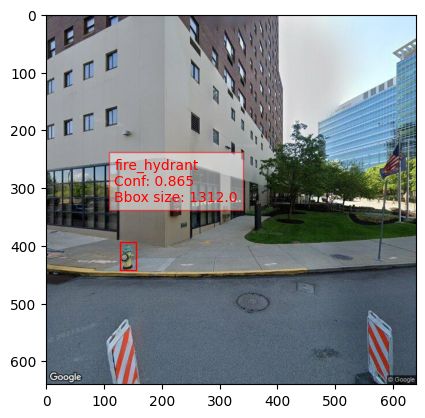

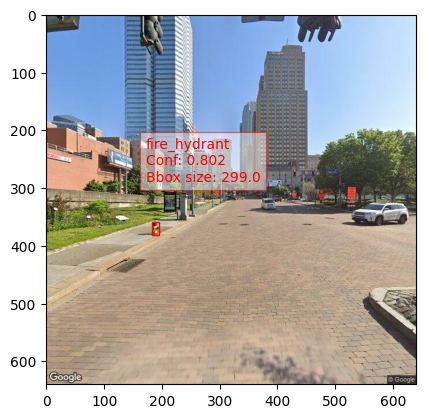

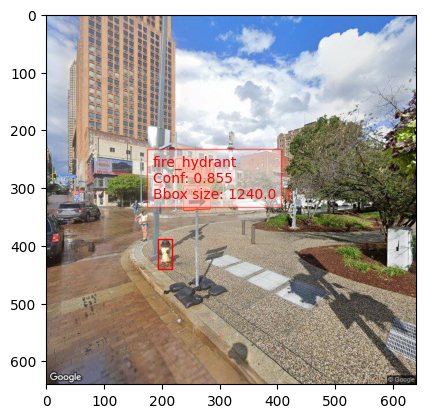

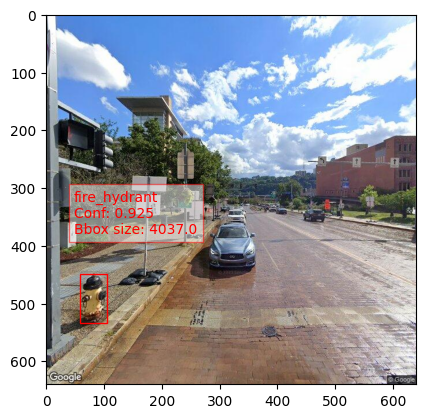

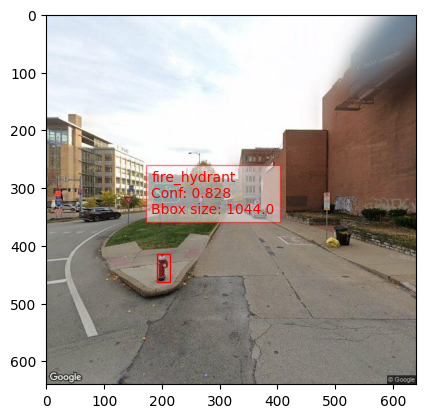

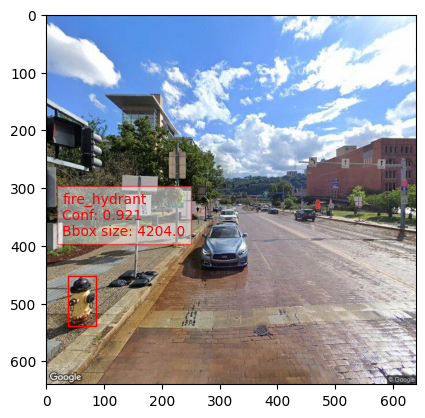

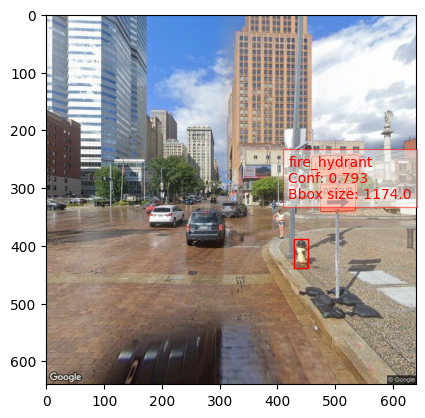

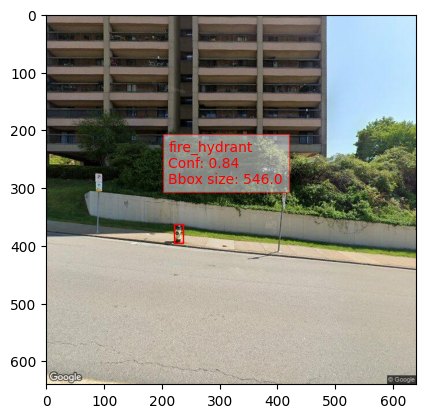

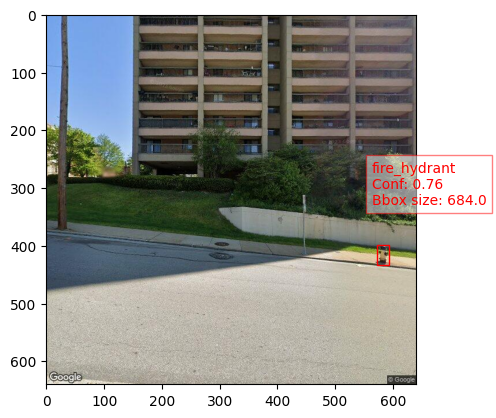

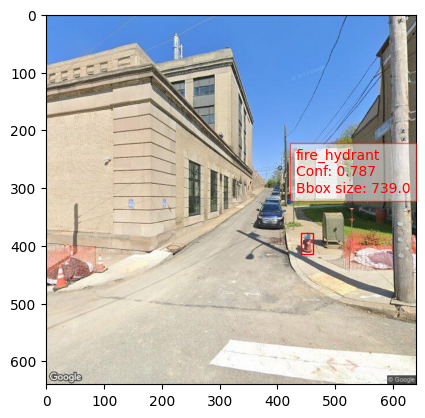

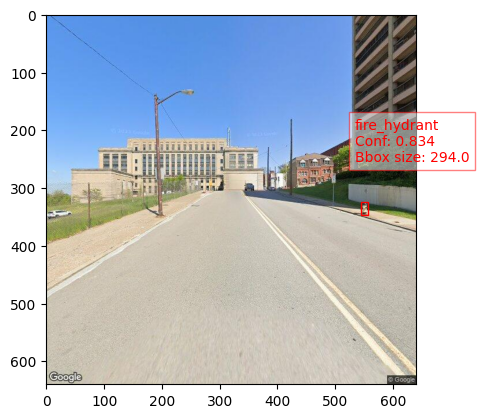

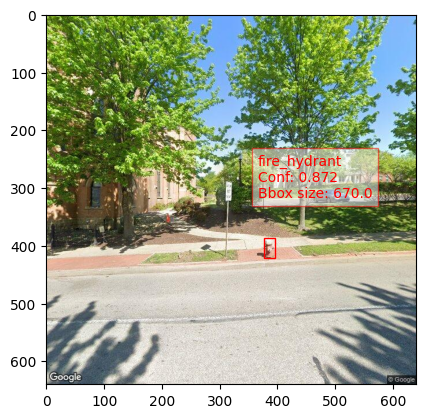

In [15]:

confidence_level = .7

counter = 0
# for each unique filename, plot all rows/images with bounding box, waiting for user input to continue
for filename in df['filename'].unique():

    # if file name is not "notsaved"
    if filename == 'NotSaved':
        continue

    # get all rows with the same filename
    df_temp = df[ (df['filename'] == filename)  ] 

    # filter on confidence level
    df_temp = df_temp[df_temp['confidence'] > confidence_level]

    # Filter on class
    df_temp = df_temp[df_temp['class'] == 'fire_hydrant']

    # if there are rows, continue
    if len(df_temp) == 0:
        continue

    # load image
    im = Image.open(os.path.join( data_root, 'GSV', 'Res_640', 'PittsburghDowntown_2024-03-20', filename))
    # plot image
    fig, ax = plt.subplots()
    ax.imshow(im)
    # plot bbox - using x1,x2,y1,y2
    for i in range(len(df_temp)):
        x1 = df_temp.iloc[i]['x1']
        x2 = df_temp.iloc[i]['x2']
        y1 = df_temp.iloc[i]['y1']
        y2 = df_temp.iloc[i]['y2']
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        # add label from "class" column and confidence / bbox size
        
        conf_text = 'Conf: ' + str( round(df_temp.iloc[i]['confidence'], 3))
        bbox_text = 'Bbox size: ' + str(round(df_temp.iloc[i]['bbox_size'], 0))

        t = plt.text(x1-10, y1-70, df_temp.iloc[i]['class'] + '\n' + conf_text + '\n' + bbox_text, color='red')
        t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='red'))

    plt.show()
    input('Press Enter to continue...')

    if counter > 10:
         break
    counter += 1

